In [1]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator, FuncFormatter

import gc

from sklearn.metrics import roc_curve, auc, roc_auc_score
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2

In [2]:
from cycler import cycler
import matplotlib

# Set the color cycle
#plt.rc('axes', prop_cycle=cycler('color', ['#73b06f', '#e6701b', '#007090', '#c7463d', '#ffad08', '#6f73b0', '#56b4e9', '#4c6e3d', '#c47ca2', '#f5f575']))
# https://coolors.co/542344-f68e5f-e5e059-007ea7-98e2c6
plt.rc('axes', prop_cycle=cycler('color', ['#73b06f', '#e6701b', '#007090', '#e7298a', '#802392', '#ffad08', '#56b4e9']))

# Configure Matplotlib to use LaTeX fonts
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"

# Set font sizes
matplotlib.rcParams.update(
    {
        "font.size": 16,  # General font size
    }
)

In [3]:
def load_data(file_name):
    file = uproot.open(file_name)
    tree = file['Events;1']
    data = tree.arrays(library="np")
    return data

First test of lgatr on 1 mio data fastsim CLD - didn't track the training so weeeell. But here we go:

In [4]:

path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimCLD240_t2.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/lgatr/test_lgatr-fastsimCLD.root"

data1 = load_data(path1)
data2 = load_data(path2)

In [4]:
def invalid_ind(data):
    ind = []
    labels = ['U', 'D', 'C', 'S', 'B', 'G', 'TAU']
    for l in labels: 
        true_labels = data[f'recojet_is{l}']
        scores = data[f'score_recojet_is{l}']
        valid_indices = np.where(np.isnan(scores))
        ind.append(valid_indices)
    return np.unique(ind)

In [5]:
def get_y_true_and_score(data):
    labels = ['U', 'D', 'C', 'S', 'B', 'G', 'TAU']
    y_true = np.array([data[f'recojet_is{label}'] for label in labels])
    y_true = np.argmax(y_true.T, axis=1)
    y_score = np.array([data[f'score_recojet_is{label}'] for label in labels])
    #print(y_score.shape)
    ind_nan = invalid_ind(data)
    #print(ind_nan)
    #print(ind_nan.shape)
    y_score = np.delete(y_score, ind_nan, axis=1)
    y_true = np.delete(y_true, ind_nan)
    return y_true, y_score.T

In [6]:
def log_multiline_rocs_b(y_true, y_score, labels, ax, k,j, ls="solid", l=True):
    q_tag = 4 # b-tagging
    vs_tag = [1,2, 5] # g, u, c
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)


    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0:
        # Calculate TPR for different ROC curves (this function needs to be defined elsewhere)
        #calculate_and_log_tpr_1_10_percent(_bg[0], _bg[1], "b", "g")
        #calculate_and_log_tpr_1_10_percent(_bud[0], _bud[1], "b", "ud")
        #calculate_and_log_tpr_1_10_percent(_bc[0], _bc[1], "b", "c")

        # Plot ROC curves
        xs = [_bg[1], _bud[1], _bc[1]]
        ys = [_bg[0], _bud[0], _bc[0]]
        auc_ = [_bg[2], _bud[2], _bc[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k,j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k,j].grid()
        ax[k,j].set_ylim(-3, 0)
        ax[k,j].set_xlabel("jet tagging efficiency")
        ax[k,j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")


def log_multiline_rocs_c(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 2 # b-tagging
    vs_tag = [1,4, 5] # ud, b, g
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0:
        xs = [_bg[1], _bud[1], _bc[1]]
        ys = [_bg[0], _bud[0], _bc[0]]
        auc_ = [_bg[2], _bud[2], _bc[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")

def log_multiline_rocs_s(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 3 # s-tagging
    vs_tag = [1,2, 4, 5] # ud, b, g
    # colors 
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)
    _bs = create_binary_rocs(q_tag, vs_tag[3], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0 and len(_bs) > 0:
        xs = [_bg[1], _bud[1], _bc[1], _bs[1]]
        ys = [_bg[0], _bud[0], _bc[0], _bs[0]]
        auc_ = [_bg[2], _bud[2], _bc[2], _bs[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")


def log_multiline_rocs_g(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 5 # g-tagging
    vs_tag = [1,2, 3, 4] # ud, b, g
    # colors 
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)
    _bs = create_binary_rocs(q_tag, vs_tag[3], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0 and len(_bs) > 0:
        xs = [_bg[1], _bud[1], _bc[1], _bs[1]]
        ys = [_bg[0], _bud[0], _bc[0], _bs[0]]
        auc_ = [_bg[2], _bud[2], _bc[2], _bs[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")

In [7]:
def all_rocs(label1, label2, save=False, name=None):
    labels = ['ud', 'ud', 'c', 's', 'b', 'g', 'tau']
    fig, ax = plt.subplots(2, 2, figsize=(12, 7), constrained_layout=True)
    y_true, y_score = get_y_true_and_score(data1)


    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1)

    y_true, y_score = get_y_true_and_score(data2)

    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0, ls="dashed", l=False)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1, ls="dashed", l=False)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0, ls="dashed", l=False)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1, ls="dashed", l=False)


    # Create the first legend for colorful ROC curves
    handles_colorful, labels_colorful = ax[0,0].get_legend_handles_labels()
    legend_colorful = ax[0,0].legend(handles=handles_colorful, title=f"{labels[4]}-tagging", title_fontproperties={'weight':'bold'})

    # Create black lines for FullSim and FastSim
    fullsim_line = Line2D([0], [0], color='black', linestyle='-', label=label1)
    fastsim_line = Line2D([0], [0], color='black', linestyle='--', label=label2)

    # Add the second legend for FullSim and FastSim
    legend_sim = ax[0,0].legend(handles=[fullsim_line, fastsim_line], loc="upper center", bbox_to_anchor=(0.6, 1.0))

    # Add back the first legend (colorful ROC curves) to the plot
    ax[0,0].add_artist(legend_colorful)
    # Re-enable the grid for all subplots
    for row in range(2):
        for col in range(2):
            ax[row, col].grid(True)  # Make sure the grid is visible
    
    if save:
        plt.savefig("./plots-for-FCC-note/{}.pdf".format(name))
    plt.show()

In [8]:
# from https://github.com/doloresgarcia/LOGML_2024/blob/81dfa6428bdd6e652908562474cded362d2bf5f6/src/utils/logger_wandb.py#L204 
def create_binary_rocs(positive, negative, y_true, y_score):
    mask_positive = y_true == positive
    if negative == 0 or negative == 1: # merge u and d
        mask_negative = np.logical_or(y_true == 0, y_true == 1)# is that correct???
    else:
        mask_negative = y_true == negative
    #print("mask positive shape", mask_positive.shape)
    number_positive = np.sum(mask_positive)
    #print("number positive", number_positive)
    number_negative = np.sum(mask_negative)

    if number_positive > 0 and number_negative > 0:
        # Create binary labels for positive and negative classes
        y_true_positive = np.ones(number_positive)
        y_true_negative = np.zeros(number_negative)
        y_true_ = np.concatenate([y_true_positive, y_true_negative]) # array like [1,1,1,...,0,0,0,0]

        # Select scores for positive and negative classes
        y_score_positive = y_score[mask_positive]
        y_score_negative = y_score[mask_negative]

        indices = np.array([negative, positive]) # [2,4]
        y_score_selected_positive = y_score_positive[:, indices] # from all MC positive scores (true MC b) take all probabilities for b and c 
        y_score_selected_negative = y_score_negative[:, indices] # from all MC netagive scores (true MC c) talke all probabilities for b and c

        # Calculate probabilities to get binary!!
        y_scores_pos_prob = y_score_selected_positive / np.sum(
            y_score_selected_positive, axis=1, keepdims=True
        )
        y_scores_neg_prob = y_score_selected_negative / np.sum(
            y_score_selected_negative, axis=1, keepdims=True
        )
        if np.isnan(y_scores_pos_prob).any() or np.isnan(y_scores_neg_prob).any():
            print("Dropping events due to nans...")
            ind_pos_nan = np.isnan(y_scores_pos_prob).any(axis=1)
            ind_neg_nan = np.isnan(y_scores_neg_prob).any(axis=1)
            y_scores_pos_prob = y_scores_pos_prob[~ind_pos_nan]
            y_scores_neg_prob = y_scores_neg_prob[~ind_neg_nan]
            # also modify y_true_ and drop values
            y_true_ = np.concatenate([np.ones(number_positive - np.sum(ind_pos_nan)), np.zeros(number_negative - np.sum(ind_neg_nan))])

        log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
        log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))

        # Extract the probability for the positive class
        y_prob_positiveclass = y_scores_pos_prob[:, 1] # 1, so that b is selected
        y_prob_positiveclass_neg = y_scores_neg_prob[:, 1]

        # Concatenate probabilities for positive and negative classes
        y_prob_positive = np.concatenate([y_prob_positiveclass, y_prob_positiveclass_neg])

        y_prob_positive_log = np.concatenate([log_y_scores_pos[:,1], log_y_scores_neg[:,1]])

        # Compute ROC curve and AUC score

        if np.isinf(y_prob_positive_log).any(): # or np.isinf(y_prob_positive_log).any():
            print("Dropping events due to infs...")
            # Drop invalid indices
            ind_inf = np.isinf(y_prob_positive_log)
            y_prob_positive_log = y_prob_positive_log[~ind_inf]
            y_true_ = y_true_[~ind_inf]

        try:
            fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive_log, pos_label=1)
            auc_score = roc_auc_score(y_true_, y_prob_positive_log)
        except: 
            print("Failed to calculate ROC curve with log probabilities.")
            fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive, pos_label=1)
            auc_score = roc_auc_score(y_true_, y_prob_positive)

        return [fpr, tpr, auc_score]#, y_true_, y_prob_positive, y_prob_positive_log]
    else:
        return []


In [10]:
# from https://github.com/doloresgarcia/LOGML_2024/blob/81dfa6428bdd6e652908562474cded362d2bf5f6/src/utils/logger_wandb.py#L204 
def create_binary_rocs(positive, negative, y_true, y_score):
    mask_positive = y_true == positive
    if negative == 0 or negative == 1: # merge u and d
        mask_negative = np.logical_or(y_true == 0, y_true == 1)# is that correct???
    else:
        mask_negative = y_true == negative
    #print("mask positive shape", mask_positive.shape)
    number_positive = np.sum(mask_positive)
    #print("number positive", number_positive)
    number_negative = np.sum(mask_negative)

    if number_positive > 0 and number_negative > 0:
        # Create binary labels for positive and negative classes
        y_true_positive = np.ones(number_positive)
        y_true_negative = np.zeros(number_negative)
        y_true_ = np.concatenate([y_true_positive, y_true_negative]) # array like [1,1,1,...,0,0,0,0]

        # Select scores for positive and negative classes
        y_score_positive = y_score[mask_positive]
        y_score_negative = y_score[mask_negative]

        indices = np.array([negative, positive]) # [2,4]
        y_score_selected_positive = y_score_positive[:, indices] # from all MC positive scores (true MC b) take all probabilities for b and c 
        y_score_selected_negative = y_score_negative[:, indices] # from all MC netagive scores (true MC c) talke all probabilities for b and c

        # Calculate probabilities to get binary!!
        y_scores_pos_prob = np.exp(y_score_selected_positive) / np.sum(
            np.exp(y_score_selected_positive), axis=1, keepdims=True
        )
        y_scores_neg_prob = np.exp(y_score_selected_negative) / np.sum(
            np.exp(y_score_selected_negative), axis=1, keepdims=True
        )
        if np.isnan(y_scores_pos_prob).any() or np.isnan(y_scores_neg_prob).any():
            print("Dropping events due to nans...")
            ind_pos_nan = np.isnan(y_scores_pos_prob).any(axis=1)
            ind_neg_nan = np.isnan(y_scores_neg_prob).any(axis=1)
            y_scores_pos_prob = y_scores_pos_prob[~ind_pos_nan]
            y_scores_neg_prob = y_scores_neg_prob[~ind_neg_nan]
            # also modify y_true_ and drop values
            y_true_ = np.concatenate([np.ones(number_positive - np.sum(ind_pos_nan)), np.zeros(number_negative - np.sum(ind_neg_nan))])

        log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
        log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))

        # Extract the probability for the positive class
        y_prob_positiveclass = y_scores_pos_prob[:, 1] # 1, so that b is selected
        y_prob_positiveclass_neg = y_scores_neg_prob[:, 1]

        # Concatenate probabilities for positive and negative classes
        y_prob_positive = np.concatenate([y_prob_positiveclass, y_prob_positiveclass_neg])

        y_prob_positive_log = np.concatenate([log_y_scores_pos[:,1], log_y_scores_neg[:,1]])

        # Compute ROC curve and AUC score

        if np.isinf(y_prob_positive_log).any(): # or np.isinf(y_prob_positive_log).any():
            print("Dropping events due to infs...")
            # Drop invalid indices
            ind_inf = np.isinf(y_prob_positive_log)
            y_prob_positive_log = y_prob_positive_log[~ind_inf]
            y_true_ = y_true_[~ind_inf]

        try:
            fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive_log, pos_label=1)
            auc_score = roc_auc_score(y_true_, y_prob_positive_log)
        except: 
            print("Failed to calculate ROC curve with log probabilities.")
            fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive, pos_label=1)
            auc_score = roc_auc_score(y_true_, y_prob_positive)

        return [fpr, tpr, auc_score]#, y_true_, y_prob_positive, y_prob_positive_log]
    else:
        return []


In [8]:
def create_binary_rocs(positive, negative, y_true, y_score):
    # Create masks for the positive and negative classes
    mask_positive = y_true == positive
    mask_negative = y_true == negative
    number_positive = np.sum(mask_positive)
    number_negative = np.sum(mask_negative)

    if number_positive > 0 and number_negative > 0:
        # Create binary labels
        y_true_positive = np.ones(number_positive)
        y_true_negative = np.zeros(number_negative)
        y_true_binary = np.concatenate([y_true_positive, y_true_negative])

        # Extract scores for the positive and negative classes
        y_score_positive = y_score[mask_positive]
        y_score_negative = y_score[mask_negative]

        # Select scores for the relevant classes
        indices = np.array([negative, positive])  # Indices for negative and positive
        y_scores_selected_positive = y_score_positive[:, indices]
        y_scores_selected_negative = y_score_negative[:, indices]

        # No normalization step here; use raw scores directly
        y_prob_positiveclass = y_scores_selected_positive[:, 1]
        y_prob_positiveclass_neg = y_scores_selected_negative[:, 1]

        # Combine scores for positive and negative examples
        y_prob_combined = np.concatenate([y_prob_positiveclass, y_prob_positiveclass_neg])

        # Compute ROC curve and AUC score
        fpr, tpr, thresholds = roc_curve(y_true_binary, y_prob_combined, pos_label=1)
        auc_score = roc_auc_score(y_true_binary, y_prob_combined)

        return [fpr, tpr, auc_score]
    else:
        return []


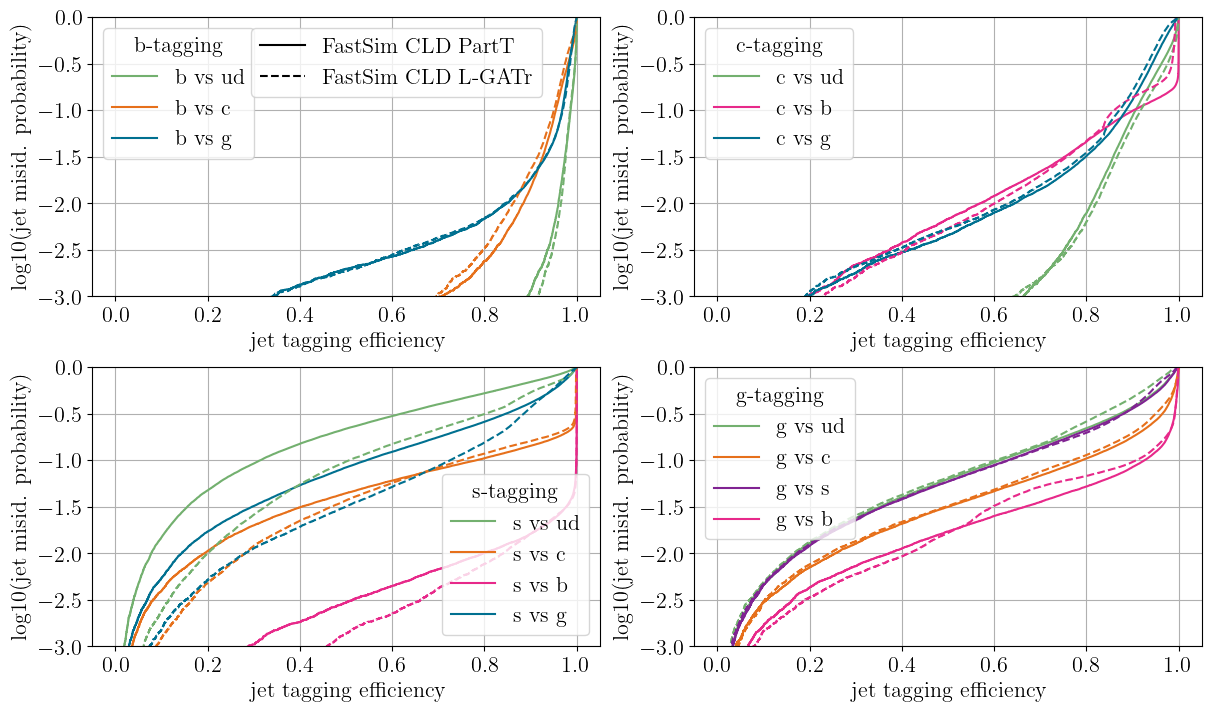

In [37]:

path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimCLD240_t2.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/lgatr/test_lgatr-fastsimCLD.root"

data1 = load_data(path1)
data2 = load_data(path2)

all_rocs('FastSim CLD PartT', 'FastSim CLD L-GATr', save=False)

## 2 mio dataset

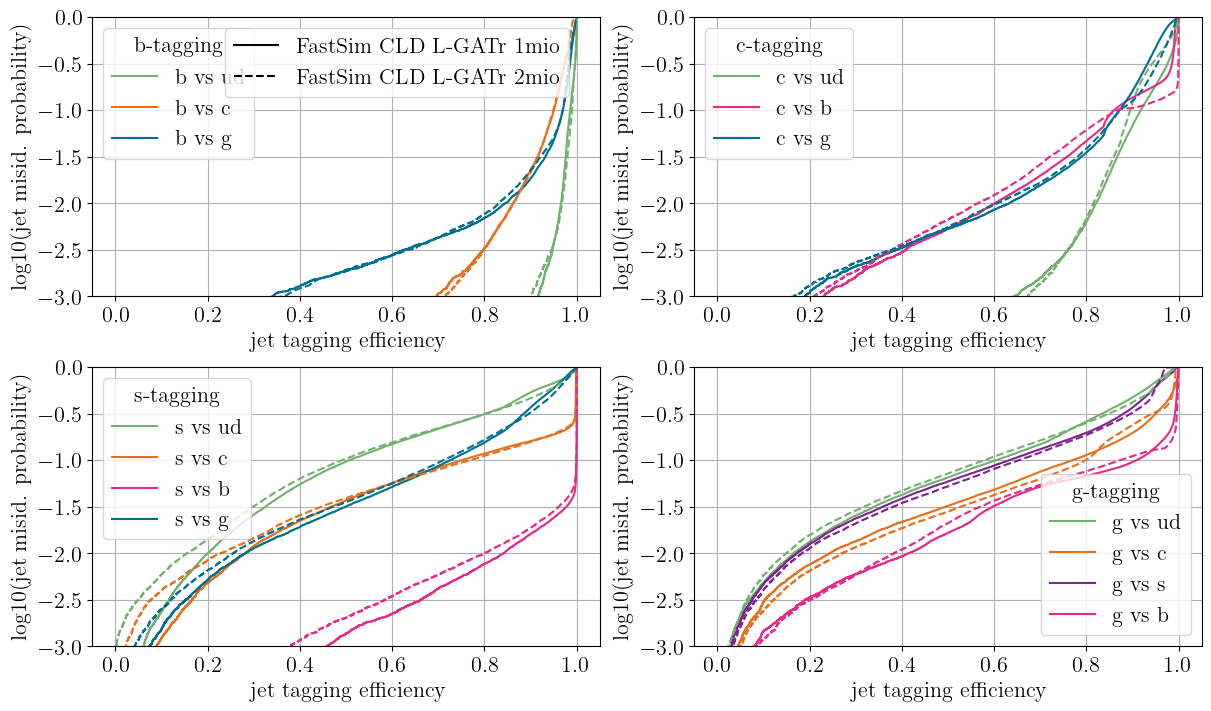

In [14]:

path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/lgatr/test_lgatr-fastsimCLD.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/lgatr/lgatr-fastsimCLD_2mio.root"

data1 = load_data(path1)
data2 = load_data(path2)

all_rocs('FastSim CLD L-GATr 1mio', 'FastSim CLD L-GATr 2mio', save=False)

## Break invariance

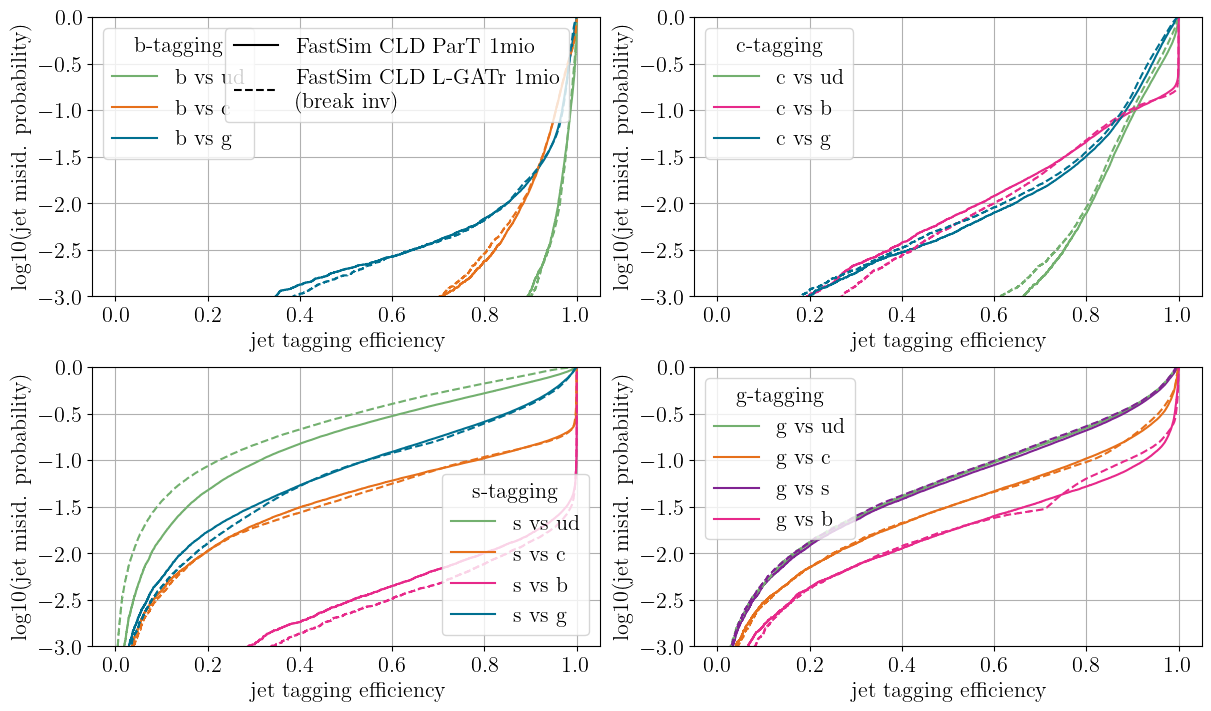

In [13]:

path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimCLD240_t2.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/lgatr/lgatr-fastsimCLD_1mio_break_inv.root"

data1 = load_data(path1)
data2 = load_data(path2)

all_rocs('FastSim CLD ParT 1mio', 'FastSim CLD L-GATr 1mio\n(break inv)', save=False)

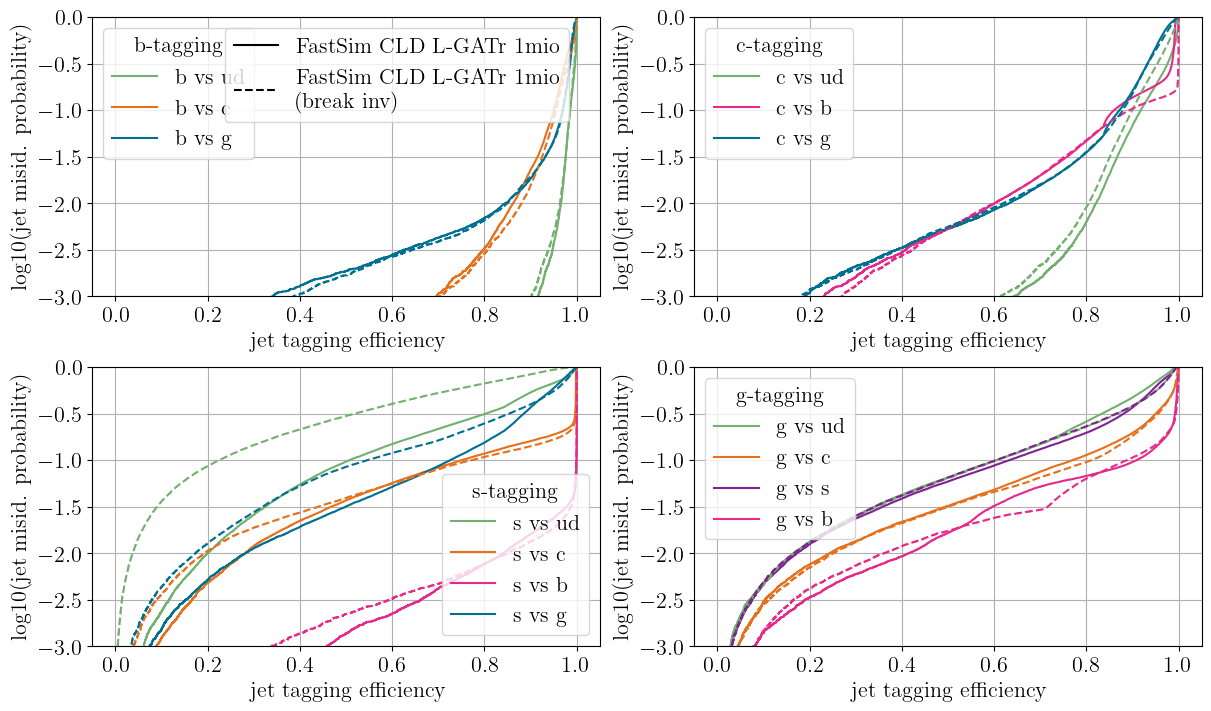

In [15]:
# the 1 mio L-GATr still has PID info due to providing p and E!

path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/lgatr/test_lgatr-fastsimCLD.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/lgatr/lgatr-fastsimCLD_1mio_break_inv.root"

data1 = load_data(path1)
data2 = load_data(path2)

all_rocs('FastSim CLD L-GATr 1mio', 'FastSim CLD L-GATr 1mio\n(break inv)', save=False)

# add node 

Add a master node from which to read from

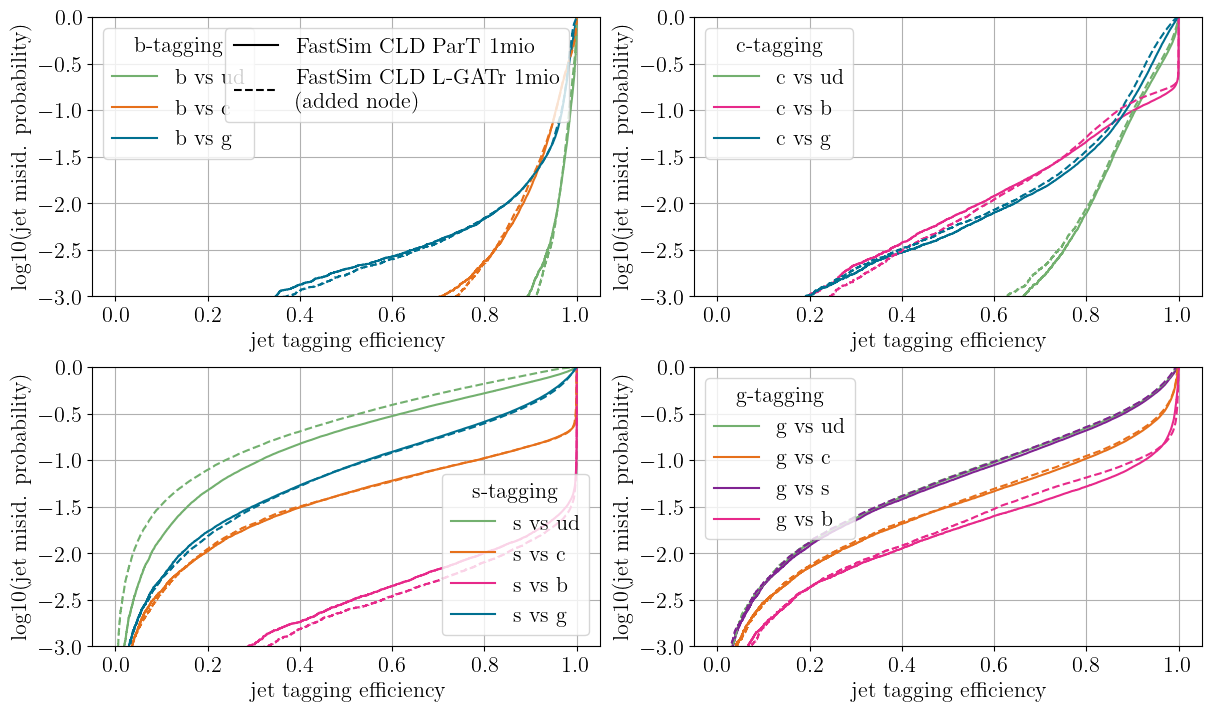

In [11]:

path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimCLD240_t2.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/lgatr/lgatr-fastsimCLD_1mio_add_node.root"

data1 = load_data(path1)
data2 = load_data(path2)

all_rocs('FastSim CLD ParT 1mio', 'FastSim CLD L-GATr 1mio\n(added node)', save=False)

## Check if softmax vs. sum normalization makes a difference

In [21]:
def log_multiline_rocs_b(y_true, y_score, labels, ax, k,j, ls="solid", l=True):
    q_tag = 4 # b-tagging
    vs_tag = [1,2, 5] # g, u, c
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if ls=="solid":
        method = "softmax"
    else:
        method = "sum"
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score, method=method)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score, method=method)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score, method=method)


    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0:
        # Calculate TPR for different ROC curves (this function needs to be defined elsewhere)
        #calculate_and_log_tpr_1_10_percent(_bg[0], _bg[1], "b", "g")
        #calculate_and_log_tpr_1_10_percent(_bud[0], _bud[1], "b", "ud")
        #calculate_and_log_tpr_1_10_percent(_bc[0], _bc[1], "b", "c")

        # Plot ROC curves
        xs = [_bg[1], _bud[1], _bc[1]]
        ys = [_bg[0], _bud[0], _bc[0]]
        auc_ = [_bg[2], _bud[2], _bc[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k,j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k,j].grid()
        ax[k,j].set_ylim(-3, 0)
        ax[k,j].set_xlabel("jet tagging efficiency")
        ax[k,j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")


def log_multiline_rocs_c(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 2 # b-tagging
    vs_tag = [1,4, 5] # ud, b, g
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if ls=="solid":
        method = "softmax"
    else:
        method = "sum"
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score, method=method)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score, method=method)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score, method=method)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0:
        xs = [_bg[1], _bud[1], _bc[1]]
        ys = [_bg[0], _bud[0], _bc[0]]
        auc_ = [_bg[2], _bud[2], _bc[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")

def log_multiline_rocs_s(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 3 # s-tagging
    vs_tag = [1,2, 4, 5] # ud, b, g
    # colors 
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if ls=="solid":
        method = "softmax"
    else:
        method = "sum"
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score, method=method)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score, method=method)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score, method=method)
    _bs = create_binary_rocs(q_tag, vs_tag[3], y_true, y_score, method=method)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0 and len(_bs) > 0:
        xs = [_bg[1], _bud[1], _bc[1], _bs[1]]
        ys = [_bg[0], _bud[0], _bc[0], _bs[0]]
        auc_ = [_bg[2], _bud[2], _bc[2], _bs[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")


def log_multiline_rocs_g(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 5 # g-tagging
    vs_tag = [1,2, 3, 4] # ud, b, g
    # colors 
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if ls=="solid":
        method = "softmax"
    else:
        method = "sum"
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score, method=method)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score, method=method)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score, method=method)
    _bs = create_binary_rocs(q_tag, vs_tag[3], y_true, y_score, method=method)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0 and len(_bs) > 0:
        xs = [_bg[1], _bud[1], _bc[1], _bs[1]]
        ys = [_bg[0], _bud[0], _bc[0], _bs[0]]
        auc_ = [_bg[2], _bud[2], _bc[2], _bs[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")

In [28]:
# from https://github.com/doloresgarcia/LOGML_2024/blob/81dfa6428bdd6e652908562474cded362d2bf5f6/src/utils/logger_wandb.py#L204 
def create_binary_rocs(positive, negative, y_true, y_score, method='softmax'):
    mask_positive = y_true == positive
    if negative == 0 or negative == 1: # merge u and d
        mask_negative = np.logical_or(y_true == 0, y_true == 1)# is that correct???
    else:
        mask_negative = y_true == negative
    #print("mask positive shape", mask_positive.shape)
    number_positive = np.sum(mask_positive)
    #print("number positive", number_positive)
    number_negative = np.sum(mask_negative)

    if number_positive > 0 and number_negative > 0:
        # Create binary labels for positive and negative classes
        y_true_positive = np.ones(number_positive)
        y_true_negative = np.zeros(number_negative)
        y_true_ = np.concatenate([y_true_positive, y_true_negative]) # array like [1,1,1,...,0,0,0,0]

        # Select scores for positive and negative classes
        y_score_positive = y_score[mask_positive]
        y_score_negative = y_score[mask_negative]

        indices = np.array([negative, positive]) # [2,4]
        y_score_selected_positive = y_score_positive[:, indices] # from all MC positive scores (true MC b) take all probabilities for b and c 
        y_score_selected_negative = y_score_negative[:, indices] # from all MC netagive scores (true MC c) talke all probabilities for b and c

        # Calculate probabilities to get binary!!
        if method == 'softmax':
            y_scores_pos_prob = np.exp(y_score_selected_positive) / np.sum(
                np.exp(y_score_selected_positive), axis=1, keepdims=True
            )
            y_scores_neg_prob = np.exp(y_score_selected_negative) / np.sum(
                np.exp(y_score_selected_negative), axis=1, keepdims=True
            )
        else: 
            y_scores_pos_prob = y_score_selected_positive / np.sum(
                y_score_selected_positive, axis=1, keepdims=True
            )
            y_scores_neg_prob = y_score_selected_negative / np.sum(
                y_score_selected_negative, axis=1, keepdims=True
            )
        if np.isnan(y_scores_pos_prob).any() or np.isnan(y_scores_neg_prob).any():
            print("Dropping events due to nans...")
            ind_pos_nan = np.isnan(y_scores_pos_prob).any(axis=1)
            ind_neg_nan = np.isnan(y_scores_neg_prob).any(axis=1)
            y_scores_pos_prob = y_scores_pos_prob[~ind_pos_nan]
            y_scores_neg_prob = y_scores_neg_prob[~ind_neg_nan]
            # also modify y_true_ and drop values
            y_true_ = np.concatenate([np.ones(number_positive - np.sum(ind_pos_nan)), np.zeros(number_negative - np.sum(ind_neg_nan))])

        log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
        log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))

        # Extract the probability for the positive class
        y_prob_positiveclass = y_scores_pos_prob[:, 1] # 1, so that b is selected
        y_prob_positiveclass_neg = y_scores_neg_prob[:, 1]

        # Concatenate probabilities for positive and negative classes
        y_prob_positive = np.concatenate([y_prob_positiveclass, y_prob_positiveclass_neg])

        y_prob_positive_log = np.concatenate([log_y_scores_pos[:,1], log_y_scores_neg[:,1]])

        # Compute ROC curve and AUC score

        if np.isinf(y_prob_positive_log).any(): # or np.isinf(y_prob_positive_log).any():
            print("Dropping events due to infs...")
            # Drop invalid indices
            ind_inf = np.isinf(y_prob_positive_log)
            y_prob_positive_log = y_prob_positive_log[~ind_inf]
            y_true_ = y_true_[~ind_inf]

        if method=='softmax':
            fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive, pos_label=1)
            auc_score = roc_auc_score(y_true_, y_prob_positive)
        else:
            fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive_log, pos_label=1)
            auc_score = roc_auc_score(y_true_, y_prob_positive_log)
        #except: 
        #    print("Failed to calculate ROC curve with log probabilities.")
        #    fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive, pos_label=1)
        #    auc_score = roc_auc_score(y_true_, y_prob_positive)

        return [fpr, tpr, auc_score]#, y_true_, y_prob_positive, y_prob_positive_log]
    else:
        return []


In [29]:

path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimCLD240_t2.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimCLD240_t2.root"

data1 = load_data(path1)
data2 = load_data(path2)

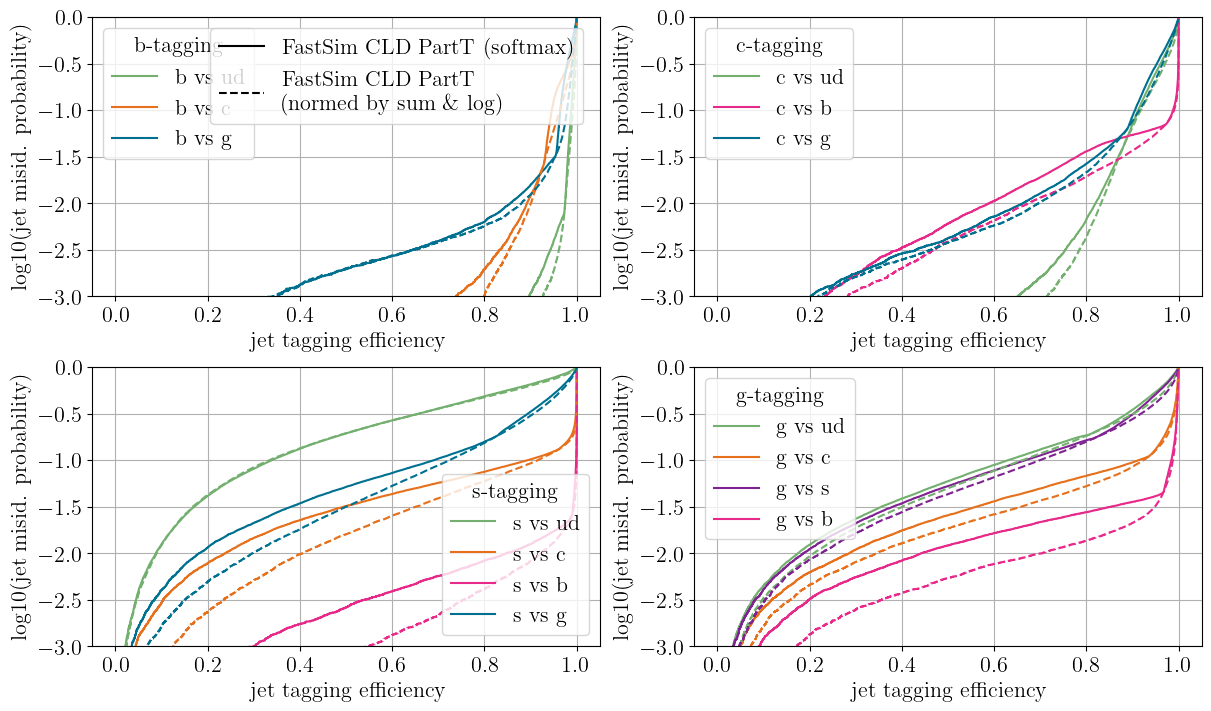

In [32]:
all_rocs('FastSim CLD PartT (softmax)', 'FastSim CLD PartT\n(normed by sum \& log)', save=False)